# Mount e Setup

In [ ]:
# Mount e Setup
from google.colab import drive
import os
import sys

drive.mount('/content/drive')

# 2. Percorso del progetto
PROJECT_PATH = '/content/drive/MyDrive/audio-restoration'

# 3. Crea la struttura delle cartelle se non esiste
os.makedirs(f'{PROJECT_PATH}/src', exist_ok=True)
os.makedirs(f'{PROJECT_PATH}/models', exist_ok=True)

# 4. Spostati nella cartella e aggiungila al path di Python
%cd {PROJECT_PATH}
if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)

print(f"✅ Setup completato! Working directory: {os.getcwd()}")


Mounted at /content/drive
/content/drive/MyDrive/audio-restoration
✅ Setup completato! Working directory: /content/drive/MyDrive/audio-restoration


In [ ]:
# Cella Setup WandB
!pip install wandb -qU  # Installa/Aggiorna la libreria

import wandb

wandb.login()


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: valalepi (valalepi-v1) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
# Installa librerie per metriche audio
!pip install torchmetrics[audio] pesq pystoi -q


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 130.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.5 MB/s eta 0:00:00


# LightweightUNET

In [ ]:
%%writefile src/model.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class LightweightUNet(nn.Module):
    """
    Ultra-lightweight U-Net per audio restoration.

    Architettura:
    - Encoder: 3 blocchi di convoluzione che riducono la dimensione temporale.
    - Decoder: 3 blocchi che riportano l'audio alla dimensione originale.
    - Skip Connections: Uniscono le feature dell'encoder col decoder per preservare i dettagli.

    Input: [batch, 1, 48000] (Tensore audio mono: 3 sec @ 16kHz)
    Output: [batch, 1, 48000] (Audio restaurato)
    """
    def __init__(self):
        super().__init__()

        # --- ENCODER (Contracting Path) ---
        # Aumentiamo i canali (profondità) e riduciamo il tempo (pooling)

        #Layers della rete neurale, estrazione di features:
        # All'inizio (enc1 - 16 canali): La rete guarda pezzettini piccolissimi di audio. Qui impara feature molto "basse" e grezze, tipo: c'è un picco di volume qui? C'è un silenzio lì?
        # A metà (enc2 - 32 canali): Mettendo insieme le informazioni grezze, inizia a riconoscere pattern più complessi, tipo: questa è una frequenza bassa, questo è un attacco di tamburo.
        # Verso la fine (enc3 - 64 canali): Le feature diventano ancora più astratte. La rete non vede più solo numeri, ma "concetti" sonori.

        # Blocco 1: Da 1 canale (audio mono) a 16 features
        self.enc1 = self._conv_block(1, 16)
        self.pool1 = nn.MaxPool1d(kernel_size=2) # Dimezza la lunghezza temporale (48k -> 24k)

        # Blocco 2: Da 16 a 32 features
        self.enc2 = self._conv_block(16, 32)
        self.pool2 = nn.MaxPool1d(kernel_size=2) # 24k -> 12k

        # Blocco 3: Da 32 a 64 features
        self.enc3 = self._conv_block(32, 64)
        self.pool3 = nn.MaxPool1d(kernel_size=2) # 12k -> 6k

        # --- BOTTLENECK ---
        # Il punto più "profondo" della rete. Qui l'audio è molto compresso
        # rappresentando caratteristiche astratte di alto livello in uno spazio latente.
        self.bottleneck = self._conv_block(64, 128)

        #Cosa sta realmente succedendo?
        #La rete è come se avesse seguito queste istruzioni:
        # Prendi questo audio rumoroso, estrai le sue caratteristiche fondamentali (Encoder),
        # riassumilo all'osso nel Bottleneck (così il rumore si perde per strada),
        # e poi usa quel riassunto pulito per ricostruire l'audio originale (Decoder, fase successiva)

        # --- DECODER (Expanding Path) ---
        # Usiamo ConvTranspose1d per fare l'operazione inversa (Upsampling)

        # Upsample 1: 6k -> 12k
        self.upconv3 = nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2)
        # Nota: input 128 perché riceve: 64 dallo skip connection + 64 dall'upconv
        self.dec3 = self._conv_block(128, 64)

        # Dal basso (Upconv): Arriva l'informazione dal Bottleneck. È ricca di significato ("qui c'è un basso") ma povera di dettaglio spaziale.
        # Il layer upconv3 trasforma i 128 canali del bottleneck in 64 canali.
        # Dal lato (Skip Connection): La rete va a ripescare quello che aveva salvato nell'Encoder allo stesso livello (e3).
        # Quell'informazione non è mai passata per il bottleneck! È "fresca", piena di dettagli originali. Anche lei ha 64 canali.

        # Upsample 2: 12k -> 24k
        self.upconv2 = nn.ConvTranspose1d(64, 32, kernel_size=2, stride=2)
        self.dec2 = self._conv_block(64, 32)

        # Upsample 3: 24k -> 48k
        self.upconv1 = nn.ConvTranspose1d(32, 16, kernel_size=2, stride=2)
        self.dec1 = self._conv_block(32, 16)

        # --- OUTPUT LAYER ---
        # Comprime le 16 feature finali in 1 singolo canale audio (waveform)
        self.final = nn.Conv1d(16, 1, kernel_size=3, padding=1)

    def _conv_block(self, in_ch, out_ch):
        """
        Helper function che crea un blocco standard:
        Conv1d -> BatchNorm -> ReLU -> Conv1d -> BatchNorm -> ReLU
        """
        return nn.Sequential(
            # Prima convoluzione: estrae features
            nn.Conv1d(in_ch, out_ch, kernel_size=3, padding=1),
            # Normalizzazione: stabilizza il training e lo rende più veloce
            nn.BatchNorm1d(out_ch),
            # Attivazione: introduce non-linearità
            nn.ReLU(inplace=True),

            # Seconda convoluzione (raffinamento)
            nn.Conv1d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # 1. Passaggio attraverso l'Encoder
        # Salviamo l'output di ogni blocco (e1, e2, e3) per le skip connections
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        # 2. Passaggio nel Bottleneck
        b = self.bottleneck(p3)

        # 3. Passaggio nel Decoder con Skip Connections

        # Livello 3
        u3 = self.upconv3(b)
        # Fix dimensioni: A volte il pooling arrotonda per difetto.
        # Se c'è discrepanza di 1 sample tra encoder e decoder, interpoliamo.
        if u3.shape != e3.shape:
            u3 = F.interpolate(u3, size=e3.shape[2:])
        #     forza u3 ad avere la stessa dimensione temporale di e3 (cioè lo stesso numero di campioni/posizioni lungo l’asse “tempo”).
        #     In pratica è un resize 1D: se u3 è lungo 6001 e e3 è lungo 6000, l’interpolazione lo riporta a 6000 (o viceversa),
        #     “stirando” o “comprimendo” leggermente i valori lungo il tempo.
        # Concatenazione: uniamo l'audio ricostruito (u3) con i dettagli originali (e3)
        u3 = torch.cat([u3, e3], dim=1)
        d3 = self.dec3(u3)

        # Livello 2
        u2 = self.upconv2(d3)
        if u2.shape != e2.shape:
            u2 = F.interpolate(u2, size=e2.shape[2:])
        u2 = torch.cat([u2, e2], dim=1)
        d2 = self.dec2(u2)

        # Livello 1
        u1 = self.upconv1(d2)
        if u1.shape != e1.shape:
            u1 = F.interpolate(u1, size=e1.shape[2:])
        u1 = torch.cat([u1, e1], dim=1)
        d1 = self.dec1(u1)

        # 4. Output finale
        out = self.final(d1)

        # RESIDUAL CONNECTION:
        # Invece di imparare l'audio da zero, la rete impara solo il "rumore" da sottrarre.
        # Out = Input (sporco) + Correzione
        out = out + x

        return out

class RestorationLoss(nn.Module):
    """
    Loss Function Ibrida:
    Combina l'errore nel tempo (forma dell'onda) con l'errore in frequenza (spettro).
    """
    def __init__(self):
        super().__init__()

    def forward(self, predicted, target):
        # 1. Loss nel dominio del tempo (L1 Loss = Mean Absolute Error)
        # Controlla se l'onda sonora combacia punto per punto
        loss_l1 = F.l1_loss(predicted, target)

        # 2. Loss nel dominio delle frequenze (FFT)
        # Trasformiamo l'audio in frequenze per controllare se il tono/timbro è giusto.
        # torch.fft.rfft calcola la Fast Fourier Transform per input reali (trasformata di Fourier).
        pred_fft = torch.fft.rfft(predicted, dim=-1)
        targ_fft = torch.fft.rfft(target, dim=-1)

        # Prendiamo solo la magnitudine (abs) ignorando la fase per ora
        # la fase è molto difficile da impare per una rete neurale,
        # inoltre l'orecchio umano percepisce meglio i cambi di magnitudine che di fase
        pred_mag = torch.abs(pred_fft)
        targ_mag = torch.abs(targ_fft)

        loss_freq = F.l1_loss(pred_mag, targ_mag)

        # Combiniamo le due loss. Il peso 0.5 è empirico.
        return loss_l1 + 0.5 * loss_freq


Overwriting src/model.py


#Dataset e Dataloaders

In [ ]:
%%writefile src/data_loader.py
import torch
from torch.utils.data import Dataset, DataLoader
import librosa
import numpy as np
from pathlib import Path

class AudioDataset(Dataset):
    """
    Gestisce il caricamento e il pre-processing dei file audio.
    Eredita da torch.utils.data.Dataset.
    """
    def __init__(self, clean_dir, degraded_dir, sr=16000, length=48000):
        self.sr = sr         # Sampling Rate (16kHz standard)
        self.length = length # Lunghezza fissa in samples (48000 = 3 secondi)

        # Cerca tutti i file .wav nella cartella 'clean'
        self.clean_files = sorted(list(Path(clean_dir).glob('*.wav')))
        self.degraded_files = []

        # Per ogni file pulito, cerca il corrispondente degradato
        for cf in self.clean_files:
            # Costruisce il path atteso: clean_dir/../degraded/nomefile.wav
            # Nota: Path(degraded_dir) deve essere il percorso completo alla cartella degraded
            df = Path(degraded_dir) / cf.name

            # Verifica che esista, altrimenti avvisa
            if df.exists():
                self.degraded_files.append(df)
            else:
                print(f"Warning: File degradato mancante per {cf.name}")

        # Stampa di debug per capire se ha trovato i file
        if len(self.clean_files) == 0:
            print(f"⚠️ ATTENZIONE: Nessun file wav trovato in {clean_dir}")

    def __len__(self):
        """Restituisce il numero totale di campioni nel dataset"""
        return len(self.clean_files)

    def __getitem__(self, idx):
        """
        Carica l'i-esimo campione dal disco
        Chiamata automaticamente dal DataLoader in loop.
        """
        # Caricamento audio con Librosa (normalizza automaticamente tra -1 e 1)
        # Gestiamo eventuali errori di lettura file
        try:
            clean, _ = librosa.load(self.clean_files[idx], sr=self.sr)
            degraded, _ = librosa.load(self.degraded_files[idx], sr=self.sr)
        except Exception as e:
            print(f"Error loading file {idx}: {e}")
            # Ritorna tensori di zeri in caso di file corrotto per non bloccare il training
            return torch.zeros(1, self.length), torch.zeros(1, self.length)

        # --- GESTIONE LUNGHEZZA FISSA ---
        # Voglio batch di dimensioni identiche.

        # CASO 1: Audio troppo corto -> Aggiungiamo zeri alla fine (Padding)
        if len(clean) < self.length:
            pad = self.length - len(clean)
            clean = np.pad(clean, (0, pad))
            degraded = np.pad(degraded, (0, pad))

        # CASO 2: Audio troppo lungo -> Tagliamo l'eccedenza (Cropping)
        # Qui prendiamo solo i primi 'length' samples per semplicità
        else:
            clean = clean[:self.length]
            degraded = degraded[:self.length]

        # Conversione in Tensori PyTorch
        # Unsqueeze(0) aggiunge la dimensione del canale: [Length] -> [1, Length]
        # È necessario perché Conv1d si aspetta [Batch, Canali, Tempo]
        clean_t = torch.FloatTensor(clean).unsqueeze(0)
        deg_t = torch.FloatTensor(degraded).unsqueeze(0)

        return deg_t, clean_t


def get_loaders(base_path, batch_size=16):
    """
   Carica i dati da cartelle già separate (train/val) su disco,
    rispettando lo split manuale fatto in fase di preparazione dati.

    Struttura attesa per ogni cartella "dataset" che viene passata:
      /train/clean
      /train/degraded
      /val/clean
      /val/degraded
    """
    train_dir = Path(base_path) / 'train'
    val_dir = Path(base_path) / 'val'

    print(f"🔍 Looking for training data in: {train_dir}")

    # Istanzia Dataset separati per Train e Val
    train_ds = AudioDataset(
        clean_dir=train_dir / 'clean',
        degraded_dir=train_dir / 'degraded'
    )

    val_ds = AudioDataset(
        clean_dir=val_dir / 'clean',
        degraded_dir=val_dir / 'degraded'
    )

    print(f"✅ Found {len(train_ds)} training samples and {len(val_ds)} validation samples.")

    # Crea i DataLoader
    #num_workers=0 perché colab aveva problemi a utilizzarne di più su Drive
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)

    # In validazione, metto Shuffle = False per avere risultati consistenti
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, val_loader


Overwriting src/data_loader.py


# Test di Forward Pass

In [ ]:
#serve solo a controllare se il modello è strutturalmente sano
import torch
from src.models import LightweightUNet, RestorationLoss

def test_forward_pass_detailed():
    print("🚦 Inizio Test Forward Pass (Senza Training)...")

    # 1. SETUP: Creiamo dati finti
    # Batch size = 2 (per vedere se gestisce più file insieme)
    # Canali = 1 (Mono)
    # Samples = 48000 (3 secondi @ 16kHz)
    batch_size = 2
    input_shape = (batch_size, 1, 48000)

    # Tensori random (numeri a caso tra -1 e 1, come un audio normalizzato)
    fake_input = torch.randn(input_shape)
    fake_target = torch.randn(input_shape)

    print(f"📦 Input Shape: {fake_input.shape}")

    # 2. MODELLO: Istanziazione
    model = LightweightUNet()

    # Conta parametri
    num_params = sum(p.numel() for p in model.parameters())
    print(f"🤖 Modello creato. Parametri totali: {num_params:,}")

    # 3. FORWARD: Passaggio nella rete
    try:
        # Qui la rete fa i calcoli (con pesi casuali iniziali)
        output = model(fake_input)

        print(f"📤 Output Shape: {output.shape}")

        # Verifica cruciale: Input e Output devono avere la stessa forma
        if output.shape == input_shape:
            print("✅ CHECK 1: Le dimensioni Input/Output corrispondono!")
        else:
            print(f"❌ ERRORE: Dimensioni diverse! {output.shape} vs {input_shape}")
            return # Interrompi se le dimensioni sono sbagliate

    except Exception as e:
        print(f"❌ ERRORE DURANTE IL FORWARD:\n{e}")
        return

    # 4. LOSS: Calcolo dell'errore
    try:
        loss_fn = RestorationLoss()
        # Calcola quanto l'output (random) è diverso dal target (random)
        loss_val = loss_fn(output, fake_target)

        print(f"📉 Loss calcolata (su dati random): {loss_val.item():.4f}")

        if not torch.isnan(loss_val):
            print("✅ CHECK 2: La Loss è un numero valido (non NaN).")
        else:
            print("❌ ERRORE: La Loss è NaN (Not a Number)!")

    except Exception as e:
        print(f"❌ ERRORE DURANTE LA LOSS:\n{e}")

    print("\n🎉 Test completato con successo. Il modello è strutturalmente sano.")

# Esegui la funzione
if __name__ == "__main__":
    test_forward_pass_detailed()


🚦 Inizio Test Forward Pass (Senza Training)...
📦 Input Shape: torch.Size([2, 1, 48000])
🤖 Modello creato. Parametri totali: 169,745
📤 Output Shape: torch.Size([2, 1, 48000])
✅ CHECK 1: Le dimensioni Input/Output corrispondono!
📉 Loss calcolata (su dati random): 62.3222
✅ CHECK 2: La Loss è un numero valido (non NaN).

🎉 Test completato con successo. Il modello è strutturalmente sano.


# Setup del Training

In [ ]:
%%writefile src/train.py
import torch
import torch.optim as optim
from pathlib import Path
from tqdm import tqdm
import wandb
import numpy as np

# Importiamo i nostri moduli
from src.models import RestorationLoss
from src.data_loader import get_loaders

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

class ModelCheckpoint:
    def __init__(self, dirpath='models/v2', best_name='best_model.pt', second_name='second_model.pt'):
        self.dirpath = Path(dirpath)
        self.dirpath.mkdir(exist_ok=True)

        self.best_path = self.dirpath / best_name
        self.second_path = self.dirpath / second_name

        self.best_loss = float('inf')
        self.second_best_loss = float('inf')

    def __call__(self, val_loss, model):
        # Caso 1: Nuova Loss è la MIGLIORE ASSOLUTA
        if val_loss < self.best_loss:
            # Sposta il vecchio best al secondo posto (se esiste)
            if self.best_path.exists():
                # Aggiorno anche il valore della loss del secondo
                self.second_best_loss = self.best_loss
                # Per coerenza logica: quello che ERA best ora diventa second.
                import shutil
                shutil.copy2(self.best_path, self.second_path)
                print(f"   🥈 Il vecchio best diventa Second Best ({self.second_best_loss:.4f})")

            # Salva il nuovo best
            self.best_loss = val_loss
            torch.save(model.state_dict(), self.best_path)
            print(f"   🥇 NUOVO BEST MODEL SALVATO! (Loss: {val_loss:.4f})")

        # Caso 2: Non è record assoluto, ma è meglio del secondo posto
        elif val_loss < self.second_best_loss:
            self.second_best_loss = val_loss
            torch.save(model.state_dict(), self.second_path)
            print(f"   🥈 Nuovo Second Best salvato (Loss: {val_loss:.4f})")


class AudioTrainer:
    def __init__(self, model, train_loader, val_loader, learning_rate=1e-3, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.learning_rate = learning_rate # Salviamo per loggarlo

        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate) #Versione evoluta di SGD Mini-Batch con Momentum
        self.criterion = RestorationLoss()

        #questo scheduler mi permette di abbassare il Learning Rate se la loss rimane uguale per 'patience' volte
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=2,
        )

        self.early_stopping = EarlyStopping(patience=4)
        self.checkpoint = ModelCheckpoint(dirpath='models/v2')

        # --- WANDB INIT ---
        # Inizializziamo il run qui dentro
        wandb.init(
            project="audio-restoration",
            config={
                "learning_rate": learning_rate,
                "architecture": "LightweightUNet",
                "dataset": "CustomAudio500+",
                "epochs": "dynamic"
            }
        )
        # Magic: traccia automaticamente gradienti e parametri del modello
        wandb.watch(self.model, log="all", log_freq=10)

    def train_epoch(self):
        self.model.train()
        total_loss = 0

        loop = tqdm(self.train_loader, desc="Training", leave=False)
        for degraded, clean in loop:
            degraded, clean = degraded.to(self.device), clean.to(self.device)

            output = self.model(degraded)
            loss = self.criterion(output, clean)

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            #Gradient Clipping: previene l'Exploding Gradient (comune con l'audio).
            #Se la "forza" complessiva (norma L2) dei gradienti supera 1.0,
            #li scala tutti verso il basso proporzionalmente per mantenere la stabilità.

            self.optimizer.step()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item()) #stampa pulito il valore della loss insieme alla barra di tqdm

            # Log per step
            wandb.log({"batch_train_loss": loss.item()})

        return total_loss / len(self.train_loader)

    def validate_epoch(self):
        self.model.eval()
        total_loss = 0

        with torch.no_grad():
            for degraded, clean in self.val_loader:
                degraded, clean = degraded.to(self.device), clean.to(self.device)
                output = self.model(degraded)
                loss = self.criterion(output, clean)
                total_loss += loss.item()

        return total_loss / len(self.val_loader)

    def fit(self, epochs):
        print(f"🚀 Avvio Training per {epochs} epoche (Logged on WandB)...")

        for epoch in range(epochs):
            train_loss = self.train_epoch()
            val_loss = self.validate_epoch()

            print(f"Epoch {epoch+1}/{epochs} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")

            # --- WANDB LOGGING ---
            # Logghiamo le metriche principali alla fine di ogni epoca
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "val_loss": val_loss,
                "learning_rate": self.optimizer.param_groups[0]['lr']
            })

            self.scheduler.step(val_loss)
            self.checkpoint(val_loss, self.model)
            self.early_stopping(val_loss)

            if self.early_stopping.early_stop:
                print("🛑 Early Stopping attivato!")
                break

        print("🎉 Training completato.")
        wandb.finish() # Chiude il run correttamente

Overwriting src/train.py


#Starter del Training

In [ ]:
# Cella di Esecuzione Training
import torch
import sys

# Ricarica i moduli per sicurezza
import importlib
if 'src.train' in sys.modules:
    importlib.reload(sys.modules['src.train'])
if 'src.models' in sys.modules:
    importlib.reload(sys.modules['src.models'])

from src.models import LightweightUNet
from src.data_loader import get_loaders
from src.train import AudioTrainer

# 1. Configurazione
BATCH_SIZE = 16
EPOCHS = 20
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"⚙️ Setup: Device={DEVICE}, Batch={BATCH_SIZE}, Epochs={EPOCHS}")

# 2. Caricamento Dati
DATA_PATH = 'data/splits_grouped'

print(f"📂 Caricamento dataset da: {DATA_PATH} ...")

train_loader, val_loader = get_loaders(DATA_PATH, batch_size=BATCH_SIZE)

# 3. Creazione Modello
print("🤖 Inizializzazione modello...")
model = LightweightUNet()

# 4. Avvio Training
print("🚀 START TRAINING!")
trainer = AudioTrainer(model, train_loader, val_loader, device=DEVICE)
trainer.fit(epochs=EPOCHS)


⚙️ Setup: Device=cuda, Batch=16, Epochs=20
📂 Caricamento dataset da: data/splits_grouped ...
🔍 Looking for training data in: data/splits_grouped/train
✅ Found 516 training samples and 132 validation samples.
🤖 Inizializzazione modello...
🚀 START TRAINING!


🚀 Avvio Training per 20 epoche (Logged on WandB)...


Epoch 1/20 | Train: 4.1152 | Val: 1.3135
   💾 Checkpoint salvato! (New best loss: 1.3135)


Epoch 2/20 | Train: 1.8121 | Val: 1.3098
   💾 Checkpoint salvato! (New best loss: 1.3098)


Epoch 3/20 | Train: 1.4709 | Val: 1.2063
   💾 Checkpoint salvato! (New best loss: 1.2063)


Epoch 4/20 | Train: 1.3474 | Val: 1.0941
   💾 Checkpoint salvato! (New best loss: 1.0941)


Epoch 5/20 | Train: 1.2705 | Val: 1.0762
   💾 Checkpoint salvato! (New best loss: 1.0762)


Epoch 6/20 | Train: 1.2919 | Val: 1.0366
   💾 Checkpoint salvato! (New best loss: 1.0366)


Epoch 7/20 | Train: 1.2366 | Val: 0.9869
   💾 Checkpoint salvato! (New best loss: 0.9869)


Epoch 8/20 | Train: 1.2606 | Val: 0.9469
   💾 Checkpoint salvato! (New best loss: 0.9469)


Epoch 9/20 | Train: 1.2184 | Val: 0.9412
   💾 Checkpoint salvato! (New best loss: 0.9412)


Epoch 10/20 | Train: 1.1953 | Val: 0.9628


Epoch 11/20 | Train: 1.1862 | Val: 0.9383
   💾 Checkpoint salvato! (New best loss: 0.9383)


Epoch 12/20 | Train: 1.1562 | Val: 0.9003
   💾 Checkpoint salvato! (New best loss: 0.9003)


Epoch 13/20 | Train: 1.1814 | Val: 0.9538


Epoch 14/20 | Train: 1.1213 | Val: 1.1843


Epoch 15/20 | Train: 1.1525 | Val: 0.9218


Epoch 16/20 | Train: 1.0779 | Val: 1.2901
🛑 Early Stopping attivato!
🎉 Training completato.


#Starter del Training v2: riprende il Training dall'ultimo Checkpoint

In [ ]:
# Cella di Esecuzione Training (FINE-TUNING VERSION)
import torch
import sys
import os
import importlib

# Ricarica moduli
if 'src.train' in sys.modules: importlib.reload(sys.modules['src.train'])
if 'src.models' in sys.modules: importlib.reload(sys.modules['src.models'])

from src.models import LightweightUNet
from src.data_loader import get_loaders
from src.train import AudioTrainer

# 1. Configurazione
BATCH_SIZE = 16
EPOCHS = 20
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT_PATH = "models/v1/best_model.pt" #modello attuale

print(f"⚙️ Setup: Device={DEVICE}, Batch={BATCH_SIZE}, Epochs={EPOCHS}")

# 2. Caricamento Dati
DATA_PATH = 'data/musicgen_finetuning/splits_grouped'
print(f"📂 Caricamento dataset da: {DATA_PATH} ...")
train_loader, val_loader = get_loaders(DATA_PATH, batch_size=BATCH_SIZE)

# 3. Creazione Modello
print("🤖 Inizializzazione modello...")
model = LightweightUNet()

# --- BLOCCO FINE-TUNING ---
if os.path.exists(CHECKPOINT_PATH):
    print(f"🔄 CARICAMENTO PESI PRE-ADDESTRATI DA: {CHECKPOINT_PATH}")
    # Carica lo stato e gestisci map_location per sicurezza
    state_dict = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    model.load_state_dict(state_dict)
    print("✅ Pesi caricati con successo. Si continua il training!")
else:
    print("⚠️ ATTENZIONE: Nessun checkpoint trovato. Il training partirà da zero (pesi random).")
# --------------------------

model = model.to(DEVICE) # Sposta su GPU prima di passare al trainer

# 4. Avvio Training
print("🚀 START FINE-TUNING!")
# Nota: L'AudioTrainer reinizializzerà l'optimizer internamente,
# ma i pesi del modello partiranno da dove li abbiamo lasciati. Perfetto.
trainer = AudioTrainer(model, train_loader, val_loader, device=DEVICE)

# Lancia il training
history = trainer.fit(epochs=EPOCHS)


⚙️ Setup: Device=cuda, Batch=16, Epochs=20
📂 Caricamento dataset da: data/musicgen_finetuning/splits_grouped ...
🔍 Looking for training data in: data/musicgen_finetuning/splits_grouped/train
✅ Found 516 training samples and 132 validation samples.
🤖 Inizializzazione modello...
🔄 CARICAMENTO PESI PRE-ADDESTRATI DA: models/v1/best_model.pt
✅ Pesi caricati con successo. Si continua il training!
🚀 START FINE-TUNING!


🚀 Avvio Training per 20 epoche (Logged on WandB)...


Epoch 1/20 | Train: 6.0797 | Val: 5.7214
   🥇 NUOVO BEST MODEL SALVATO! (Loss: 5.7214)


Epoch 2/20 | Train: 5.9689 | Val: 5.8123
   🥈 Nuovo Second Best salvato (Loss: 5.8123)


Epoch 3/20 | Train: 5.9872 | Val: 5.7308
   🥈 Nuovo Second Best salvato (Loss: 5.7308)


Epoch 4/20 | Train: 5.9314 | Val: 5.6891
   🥈 Il vecchio best diventa Second Best (5.7214)
   🥇 NUOVO BEST MODEL SALVATO! (Loss: 5.6891)


Epoch 5/20 | Train: 5.9567 | Val: 5.7482


Epoch 6/20 | Train: 5.9074 | Val: 5.7029
   🥈 Nuovo Second Best salvato (Loss: 5.7029)


Epoch 7/20 | Train: 6.0054 | Val: 5.7147


Epoch 8/20 | Train: 5.8916 | Val: 5.6704
   🥈 Il vecchio best diventa Second Best (5.6891)
   🥇 NUOVO BEST MODEL SALVATO! (Loss: 5.6704)


Epoch 9/20 | Train: 5.9501 | Val: 5.7038


Epoch 10/20 | Train: 5.8784 | Val: 5.6660
   🥈 Il vecchio best diventa Second Best (5.6704)
   🥇 NUOVO BEST MODEL SALVATO! (Loss: 5.6660)


Epoch 11/20 | Train: 5.8800 | Val: 5.6699
   🥈 Nuovo Second Best salvato (Loss: 5.6699)


Epoch 12/20 | Train: 5.9091 | Val: 5.6784


Epoch 13/20 | Train: 5.8792 | Val: 5.7072


Epoch 14/20 | Train: 5.9545 | Val: 5.6406
   🥈 Il vecchio best diventa Second Best (5.6660)
   🥇 NUOVO BEST MODEL SALVATO! (Loss: 5.6406)


Epoch 15/20 | Train: 5.8822 | Val: 5.6587
   🥈 Nuovo Second Best salvato (Loss: 5.6587)


Epoch 16/20 | Train: 5.8710 | Val: 5.6509
   🥈 Nuovo Second Best salvato (Loss: 5.6509)


Epoch 17/20 | Train: 5.8923 | Val: 5.6259
   🥈 Il vecchio best diventa Second Best (5.6406)
   🥇 NUOVO BEST MODEL SALVATO! (Loss: 5.6259)


Epoch 18/20 | Train: 5.8959 | Val: 5.6336
   🥈 Nuovo Second Best salvato (Loss: 5.6336)


Epoch 19/20 | Train: 5.8402 | Val: 5.6265
   🥈 Nuovo Second Best salvato (Loss: 5.6265)


Epoch 20/20 | Train: 5.8975 | Val: 5.6387
🎉 Training completato.


#Starter del training v3 (con conservazione modello precedente)

In [ ]:
# --- CONFIGURAZIONE NUOVO ROUND (V3) ---

# Cella di Training V3: qui è dove ho creato v2.1 e v2.2
import torch
import sys
import os
import importlib
from pathlib import Path

# Ricarica moduli
if 'src.train' in sys.modules:
  importlib.reload(sys.modules['src.train'])

from src.models import LightweightUNet
from src.data_loader import get_loaders

from src.train import AudioTrainer, ModelCheckpoint

DATA_PATH = 'data/musicgen_finetuning' # Stessi dati
BATCH_SIZE = 16
EPOCHS = 20
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Carica dall'ultimo checkpoint
LOAD_FROM_CHECKPOINT = "models/v2/best_model.pt" #per ordine, dopo il training ho cambiato i nomi delle cartelle

# 2. salva nuovo esperimento in nuova cartella
SAVE_TO_DIR = "models/v3"
Path(SAVE_TO_DIR).mkdir(parents=True, exist_ok=True) # La crea se non c'è

print(f"⚙️ Setup: Load from {LOAD_FROM_CHECKPOINT} -> Save to {SAVE_TO_DIR}")

# ... (Caricamento Dataloader e Modello) ...
model = LightweightUNet()

# Carica i pesi V2
if os.path.exists(LOAD_FROM_CHECKPOINT):
    print(f"🔄 CARICAMENTO PESI V2: {LOAD_FROM_CHECKPOINT}")
    model.load_state_dict(torch.load(LOAD_FROM_CHECKPOINT, map_location=DEVICE))
else:
    print("⚠️ ERRORE CRITICO: Non trovo il modello v2!")

model = model.to(DEVICE)

# ... (Trainer Init) ...
trainer = AudioTrainer(model, train_loader, val_loader, device=DEVICE)

# IMPORTANTE: Aggiorna il checkpoint path del trainer per puntare alla nuova cartella
trainer.checkpoint = ModelCheckpoint(
    dirpath=SAVE_TO_DIR,           # Salva in SAVE_TO_DIR specificato sopra
    best_name='best_model.pt',     # Nome file
    second_name='second_best.pt'
)

# Avvia
trainer.fit(epochs=EPOCHS)


⚙️ Setup: Load from models/v2/best_model.pt -> Save to models/v3
🔄 CARICAMENTO PESI V2: models/v2/best_model.pt


🚀 Avvio Training per 20 epoche (Logged on WandB)...


Epoch 1/20 | Train: 5.9670 | Val: 5.6678
   🥇 NUOVO BEST MODEL SALVATO! (Loss: 5.6678)


Epoch 2/20 | Train: 5.8948 | Val: 5.6469
   🥈 Il vecchio best diventa Second Best (5.6678)
   🥇 NUOVO BEST MODEL SALVATO! (Loss: 5.6469)


Epoch 3/20 | Train: 5.9265 | Val: 5.6777


Epoch 4/20 | Train: 5.8977 | Val: 5.6293
   🥈 Il vecchio best diventa Second Best (5.6469)
   🥇 NUOVO BEST MODEL SALVATO! (Loss: 5.6293)


Epoch 5/20 | Train: 5.8670 | Val: 5.6744


Epoch 6/20 | Train: 5.8971 | Val: 5.6862


Epoch 7/20 | Train: 5.8495 | Val: 5.6550


Epoch 8/20 | Train: 5.8859 | Val: 5.6285
   🥈 Il vecchio best diventa Second Best (5.6293)
   🥇 NUOVO BEST MODEL SALVATO! (Loss: 5.6285)


Epoch 9/20 | Train: 5.8526 | Val: 5.6359


Epoch 10/20 | Train: 5.8636 | Val: 5.6500


Epoch 11/20 | Train: 5.8107 | Val: 5.6563


Epoch 12/20 | Train: 5.7961 | Val: 5.6182
   🥈 Il vecchio best diventa Second Best (5.6285)
   🥇 NUOVO BEST MODEL SALVATO! (Loss: 5.6182)


Epoch 13/20 | Train: 5.8245 | Val: 5.6502


Epoch 14/20 | Train: 5.9090 | Val: 5.6023
   🥈 Il vecchio best diventa Second Best (5.6182)
   🥇 NUOVO BEST MODEL SALVATO! (Loss: 5.6023)


Epoch 15/20 | Train: 5.8262 | Val: 5.6415


Epoch 16/20 | Train: 5.8988 | Val: 5.6305


Epoch 17/20 | Train: 5.8282 | Val: 5.6133
   🥈 Nuovo Second Best salvato (Loss: 5.6133)


Epoch 18/20 | Train: 5.7889 | Val: 5.6092
   🥈 Nuovo Second Best salvato (Loss: 5.6092)
🛑 Early Stopping attivato!
🎉 Training completato.


# Inferenza

In [ ]:
%%writefile src/inference.py
import torch
import librosa
import soundfile as sf
import numpy as np
from pathlib import Path
from src.models import LightweightUNet

class AudioRestorer:
    def __init__(self, checkpoint_path, device='cuda'):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        print(f"🔊 Loading model on {self.device}...")

        # Carica architettura e pesi
        self.model = LightweightUNet().to(self.device)

        # Gestione caricamento sicuro (map_location evita errori se carichi su CPU un modello allenato su GPU)
        state_dict = torch.load(checkpoint_path, map_location=self.device)
        self.model.load_state_dict(state_dict)

        self.model.eval() #in generale, spegne BatchNorm e Dropout per l'inferenza (in questo caso, spegne in particolare BatchNorm)
        print("✅ Model loaded successfully.")

    def restore_file(self, input_path, output_path, chunk_size=48000, overlap=4000):
        """
        Restaura un file audio intero processandolo a pezzi (chunks).
        Usa overlap-add per evitare 'click' tra un pezzo e l'altro.
        """
        # Carica audio
        y, sr = librosa.load(input_path, sr=16000) #16khz

        # Prepara buffer di output e buffer per contare le sovrapposizioni
        #servono come contenitori per resturare la canzone dopo aver sistemato i chunk
        y_out = np.zeros_like(y)
        count = np.zeros_like(y)

        #per non dare la canzone intera al modello, la dividiamo in chunk che vengono uniti tra loro
        # Finestra di Hanning per ammorbidire i bordi dei chunk (cross-fade).

        # Overlap (Sovrapposizione): Invece di fare [0-3s], [3-6s], facciamo [0-3s], [2.5-5.5s]. I chunk si accavallano.
        # Hanning Window (Finestra a Campana): È una funzione matematica che assomiglia a una collina (parte da 0, sale a 1, scende a 0).
        window = np.hanning(chunk_size)

        # Loop sui chunk con passo (stride) minore della lunghezza per sovrapporre (es. [0-3s], [2.5-5.5s]).
        stride = chunk_size - overlap

        for start in range(0, len(y), stride):
            end = start + chunk_size

            # Gestione ultimo pezzetto (padding se serve)

            # Calcola quanto manca (chunk_size - len(chunk) = 44.000).
            # Aggiunge 44.000 zeri alla fine (np.pad). Ora il chunk è lungo 48.000.
            # Il modello lo processa tranquillamente.

            chunk = y[start:end]
            if len(chunk) < chunk_size:
                pad_len = chunk_size - len(chunk)
                chunk_padded = np.pad(chunk, (0, pad_len))
            else:
                chunk_padded = chunk
                pad_len = 0

            # Inferenza sul chunk
            with torch.no_grad():
                t_in = torch.FloatTensor(chunk_padded).unsqueeze(0).unsqueeze(0).to(self.device)
                t_out = self.model(t_in)
                cleaned_chunk = t_out.squeeze().cpu().numpy()

            # Rimuovi padding se c'era
            # Alla fine, tagliamo via quegli zeri aggiunti (cleaned_chunk[:-pad_len])
            #per tornare alla lunghezza originale di 4.000 e incollare il pezzo finale pulito.
            if pad_len > 0:
                cleaned_chunk = cleaned_chunk[:-pad_len]
                real_len = len(cleaned_chunk)
            else:
                real_len = chunk_size

            # Overlap-Add pesato dalla finestra
            # (Usiamo la finestra solo se il chunk è intero, altrimenti finestra adattata o niente finestra sui bordi estremi)
            # Per semplicità qui sommiamo diretto con normalizzazione media

            y_out[start:start+real_len] += cleaned_chunk
            count[start:start+real_len] += 1.0

        # Normalizza dove ci sono state sovrapposizioni
        count[count == 0] = 1.0 # Evita div per zero
        y_out = y_out / count

        # Salva
        sf.write(output_path, y_out, sr)
        return output_path


Overwriting src/inference.py


#Metriche e Logger

In [ ]:
%%writefile src/metrics.py
import torch
import torchmetrics.audio as ta
from torchmetrics.audio import ShortTimeObjectiveIntelligibility, PerceptualEvaluationSpeechQuality
from torchmetrics.functional.audio import scale_invariant_signal_distortion_ratio
import numpy as np
import librosa

class MetricsCalculator:
    def __init__(self, device='cpu'):
        self.device = device
        # Inizializziamo le metriche pesanti
        # PESQ Wideband (16kHz) è lo standard per la qualità vocale/musicale
        try:
            self.pesq = PerceptualEvaluationSpeechQuality(fs=16000, mode='wb').to(device)
            self.stoi = ShortTimeObjectiveIntelligibility(fs=16000).to(device)
            print("✅ Metriche PESQ e STOI caricate su GPU/CPU.")
        except Exception as e:
            print(f"⚠️ Attenzione: Impossibile caricare PESQ/STOI ({e}). Verranno saltate.")
            self.pesq = None
            self.stoi = None

    def calculate_all(self, clean_path, degraded_path, restored_path):
        """Calcola Si-SDR, SNR, PESQ, STOI, LSD confrontando i file audio."""

        # Caricamento forzato a 16kHz per compatibilità PESQ
        clean, _ = librosa.load(clean_path, sr=16000)
        deg, _ = librosa.load(degraded_path, sr=16000)
        rest, _ = librosa.load(restored_path, sr=16000)

        # Allineamento temporale (taglio alla lunghezza minima)
        min_len = min(len(clean), len(deg), len(rest))
        clean_t = torch.tensor(clean[:min_len]).unsqueeze(0).to(self.device)
        deg_t = torch.tensor(deg[:min_len]).unsqueeze(0).to(self.device)
        rest_t = torch.tensor(rest[:min_len]).unsqueeze(0).to(self.device)

        results = {}

        # 1. Si-SDR (Scale-Invariant Signal-to-Distortion Ratio)
        results['sisdr_baseline'] = scale_invariant_signal_distortion_ratio(deg_t, clean_t).item()
        results['sisdr_restored'] = scale_invariant_signal_distortion_ratio(rest_t, clean_t).item()

        # 2. SNR (Signal-to-Noise Ratio)
        results['snr_baseline'] = self._calculate_snr(clean_t, deg_t)
        results['snr_restored'] = self._calculate_snr(clean_t, rest_t)

        # 3. Metriche avanzate (PESQ/STOI)
        if self.pesq and self.stoi:
            try:
                results['pesq_baseline'] = self.pesq(deg_t, clean_t).item()
                results['pesq_restored'] = self.pesq(rest_t, clean_t).item()
                results['stoi_baseline'] = self.stoi(deg_t, clean_t).item()
                results['stoi_restored'] = self.stoi(rest_t, clean_t).item()
            except Exception as e:
                print(f"Errore calcolo PESQ/STOI: {e}")
                results['pesq_baseline'] = 0.0; results['pesq_restored'] = 0.0
                results['stoi_baseline'] = 0.0; results['stoi_restored'] = 0.0

        # 4. LSD (Log-Spectral Distance)
        results['lsd_baseline'] = self._calculate_lsd(clean_t, deg_t)
        results['lsd_restored'] = self._calculate_lsd(clean_t, rest_t)

        # Calcolo dei Delta (Miglioramenti)
        results['delta_sisdr'] = results['sisdr_restored'] - results['sisdr_baseline']
        results['delta_pesq'] = results.get('pesq_restored', 0) - results.get('pesq_baseline', 0)

        return results

    def _calculate_snr(self, target, preds):
        noise = target - preds
        signal_power = torch.mean(target ** 2)
        noise_power = torch.mean(noise ** 2)
        if noise_power < 1e-6: return 50.0 # Cap per audio identici
        return 10 * torch.log10(signal_power / noise_power).item()

    def _calculate_lsd(self, clean, estimate):
        clean_stft = torch.stft(clean.squeeze(), n_fft=2048, hop_length=512, return_complex=True)
        est_stft = torch.stft(estimate.squeeze(), n_fft=2048, hop_length=512, return_complex=True)
        clean_log = torch.log(torch.abs(clean_stft) + 1e-8)
        est_log = torch.log(torch.abs(est_stft) + 1e-8)
        diff = (clean_log - est_log) ** 2
        return torch.mean(torch.sqrt(torch.mean(diff, dim=1))).item()


Overwriting src/metrics.py


In [ ]:
#utile per salvare automaticamente metriche, spettrogrammi e file Crean, Degraded e restore
#in un unica cartella insieme alle note personali (quest'ultime opzionali)
%%writefile src/logger.py
import os
import shutil
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
import json
from pathlib import Path

class ExperimentLogger:
    def __init__(self, base_results_dir='results_experiments'):
        self.base_dir = Path(base_results_dir)
        self.base_dir.mkdir(exist_ok=True)

    def log_experiment(self, song_name, clean_path, degraded_path, restored_path, notes="", metrics=None):
        # Sanitizza il nome del file
        safe_name = song_name.replace(' ', '_').replace('.wav', '')
        # Crea sottocartella univoca per questo test
        exp_dir = self.base_dir / safe_name
        exp_dir.mkdir(exist_ok=True)

        print(f"\n📝 Salvataggio esperimento in: {exp_dir}")

        # 1. Copia i file Audio
        shutil.copy2(clean_path, exp_dir / "01_original.wav")
        shutil.copy2(degraded_path, exp_dir / "02_degraded.wav")
        shutil.copy2(restored_path, exp_dir / "03_restored.wav")

        # 2. Genera e salva Spettrogramma
        self._save_spectrogram_plot(clean_path, degraded_path, restored_path, exp_dir / "spectrogram_comparison.png")

        # 3. Salva le Metriche (JSON + TXT)
        if metrics:
            with open(exp_dir / "metrics.json", "w") as f:
                json.dump(metrics, f, indent=4)

            with open(exp_dir / "metrics_report.txt", "w") as f:
                f.write(f"METRICS REPORT: {song_name}\n{'='*40}\n")
                f.write(f"{'METRIC':<10} | {'BASE':<8} | {'RESTORED':<8} | {'DELTA'}\n{'-'*45}\n")
                for k in ['sisdr', 'pesq', 'stoi', 'snr', 'lsd']:
                    base = metrics.get(f'{k}_baseline', 0)
                    rest = metrics.get(f'{k}_restored', 0)
                    delta = rest - base
                    f.write(f"{k.upper():<10} | {base:<8.2f} | {rest:<8.2f} | {delta:+.2f}\n")

        # 4. Salva le Note Personali
        with open(exp_dir / "my_notes.txt", "w") as f:
            f.write(f"Esperimento: {song_name}\n")
            f.write("="*30 + "\n")
            f.write(notes + "\n")

        print("✅ Salvataggio completato: Audio, Immagini, Metriche e Note.")

    def _save_spectrogram_plot(self, c, d, r, out_path):
        # Carica audio
        y_c, sr = librosa.load(c, sr=16000)
        y_d, _ = librosa.load(d, sr=16000)
        y_r, _ = librosa.load(r, sr=16000)

        # Calcola spettrogrammi
        D_c = librosa.amplitude_to_db(np.abs(librosa.stft(y_c)), ref=np.max)
        D_d = librosa.amplitude_to_db(np.abs(librosa.stft(y_d)), ref=np.max)
        D_r = librosa.amplitude_to_db(np.abs(librosa.stft(y_r)), ref=np.max)

        # Plot
        fig, ax = plt.subplots(3, 1, figsize=(10, 12))
        librosa.display.specshow(D_c, sr=sr, x_axis='time', y_axis='hz', ax=ax[0])
        ax[0].set_title('Originale (Clean)')
        librosa.display.specshow(D_d, sr=sr, x_axis='time', y_axis='hz', ax=ax[1])
        ax[1].set_title('Degradato (Input)')
        librosa.display.specshow(D_r, sr=sr, x_axis='time', y_axis='hz', ax=ax[2])
        ax[2].set_title('Ricostruito (Output)')

        plt.tight_layout()
        plt.savefig(out_path)
        plt.close(fig)


Overwriting src/logger.py


#Cella di ascolto v1

🔄 Elaborazione: Bad Bunny - DtMF_v4.wav...
📊 Calcolo metriche...


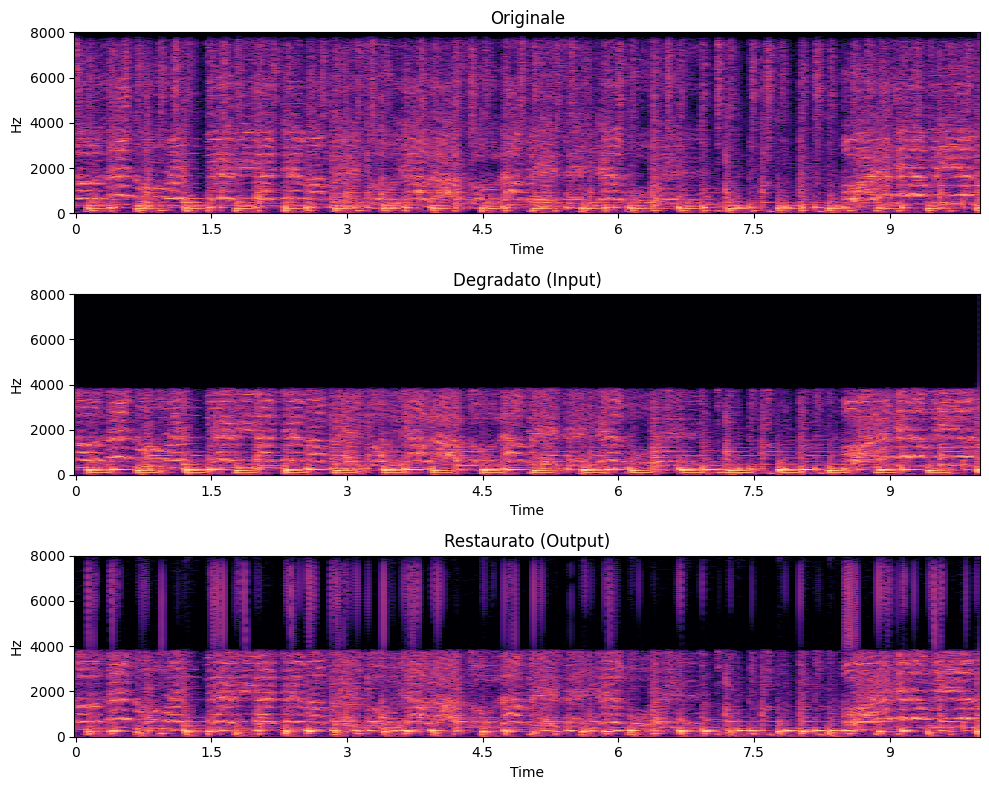


📈 REPORT METRICHE: Bad Bunny - DtMF_v4.wav
Si-SDR: 18.01 -> 17.32 (Miglioramento: -0.69)
PESQ:   3.19 -> 1.76 (Miglioramento: -1.43)
--------------------------------------------------
🎧 ASCOLTO COMPARATIVO:
1. Originale:


2. Degradato:


3. Restaurato:


In [ ]:
#test su audio nel validation
import torch
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
import numpy as np
from pathlib import Path
import sys
from importlib import reload

# Import moduli custom (con reload per sicurezza)
import src.metrics
import src.logger
reload(src.metrics)
reload(src.logger)

from src.models import LightweightUNet
from src.metrics import MetricsCalculator
from src.logger import ExperimentLogger

# --- SETUP INIZIALE ---
MODEL_CHECKPOINT = "models/best_model.pt"
CLEAN_DIR = Path("data/splits_grouped/val/clean")
DEGRADED_DIR = Path("data/splits_grouped/val/degraded")
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Caricamento Modello e Tool (Singleton)
if 'model' not in globals():
    print(f"⏳ Caricamento Modello su {DEVICE}...")
    model = LightweightUNet().to(DEVICE)
    # Gestione sicura del caricamento pesi
    if torch.cuda.is_available():
        map_loc = None
    else:
        map_loc = torch.device('cpu')

    state_dict = torch.load(MODEL_CHECKPOINT, map_location=map_loc)
    model.load_state_dict(state_dict)
    model.eval()

    metrics_calc = MetricsCalculator(device=DEVICE)
    logger = ExperimentLogger(base_results_dir='results_experiments')
    print("✅ Modello e Tool pronti.")

# ==============================================================================
# 1. SCEGLI IL FILE DA ANALIZZARE
# ==============================================================================
FILENAME = "Bad Bunny - DtMF_v4.wav"  # <--- CAMBIA SOLO QUI
# ==============================================================================

def analyze_audio(filename):
    clean_path = CLEAN_DIR / filename
    degraded_path = DEGRADED_DIR / filename
    temp_restored_path = "temp_preview.wav"

    if not degraded_path.exists():
        print(f"❌ File non trovato: {filename} in {DEGRADED_DIR}")
        return None

    print(f"🔄 Elaborazione: {filename}...")

    # A. INFERENZA
    # Carichiamo direttamente a 16kHz e in mono
    deg_np, sr = librosa.load(str(degraded_path), sr=16000, mono=True)

    # Conversione in tensore [Batch, Channels, Time] -> [1, 1, Time]
    deg_tensor = torch.from_numpy(deg_np).unsqueeze(0).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        restored_tensor = model(deg_tensor)

    # Output post-processato per salvataggio (rimuovi batch/channel dim)
    restored_np = restored_tensor.squeeze().cpu().numpy()

    # Salva con soundfile (evita errori di codec)
    sf.write(temp_restored_path, restored_np, 16000)

    # B. CALCOLO METRICHE
    print("📊 Calcolo metriche...")
    metrics = metrics_calc.calculate_all(str(clean_path), str(degraded_path), temp_restored_path)

    # C. VISUALIZZAZIONE SPETTROGRAMMI
    plt.figure(figsize=(10, 8))

    # Carica audio clean per confronto
    clean_np, _ = librosa.load(str(clean_path), sr=16000)

    # Calcola DB una volta sola per plot
    def plot_spec(y, ax, title):
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        librosa.display.specshow(D, sr=16000, x_axis='time', y_axis='hz', ax=ax)
        ax.set_title(title)

    ax1 = plt.subplot(3, 1, 1); plot_spec(clean_np, ax1, "Originale")
    ax2 = plt.subplot(3, 1, 2); plot_spec(deg_np, ax2, "Degradato (Input)")
    ax3 = plt.subplot(3, 1, 3); plot_spec(restored_np, ax3, "Restaurato (Output)")
    plt.tight_layout(); plt.show()

    # D. REPORT E ASCOLTO
    print(f"\n📈 REPORT METRICHE: {filename}")
    print(f"Si-SDR: {metrics['sisdr_baseline']:.2f} -> {metrics['sisdr_restored']:.2f} (Miglioramento: {metrics['delta_sisdr']:+.2f})")
    print(f"PESQ:   {metrics['pesq_baseline']:.2f} -> {metrics['pesq_restored']:.2f} (Miglioramento: {metrics['delta_pesq']:+.2f})")
    print("-" * 50)

    print("🎧 ASCOLTO COMPARATIVO:")
    print("1. Originale:")
    ipd.display(ipd.Audio(str(clean_path)))
    print("2. Degradato:")
    ipd.display(ipd.Audio(str(degraded_path)))
    print("3. Restaurato:")
    ipd.display(ipd.Audio(temp_restored_path))

    return {
        "filename": filename,
        "clean_path": str(clean_path),
        "degraded_path": str(degraded_path),
        "restored_path": temp_restored_path,
        "metrics": metrics
    }

# Esegui
CACHE_ESPERIMENTO = analyze_audio(FILENAME)


In [ ]:
# ==============================================================================
# 📝 SCRIVI QUI NOTE PERSONALI (opzionale)
# ==============================================================================
NOTE_PERSONALI = """

"""
# ==============================================================================

if 'CACHE_ESPERIMENTO' not in globals() or CACHE_ESPERIMENTO is None:
    print("❌ Nessun dato in memoria! Esegui prima la cella di Analisi.")
else:
    print(f"💾 Salvataggio esperimento: {CACHE_ESPERIMENTO['filename']}...")

    # Richiama il logger usando i dati cachati dalla cella precedente
    logger.log_experiment(
        song_name=CACHE_ESPERIMENTO['filename'],
        clean_path=CACHE_ESPERIMENTO['clean_path'],
        degraded_path=CACHE_ESPERIMENTO['degraded_path'],
        restored_path=CACHE_ESPERIMENTO['restored_path'],
        notes=NOTE_PERSONALI,
        metrics=CACHE_ESPERIMENTO['metrics']
    )


💾 Salvataggio esperimento: Travis Scott, Don Toliver - CHAMPAIN & VACAY_v4.wav...

📝 Salvataggio esperimento in: results_experiments/Travis_Scott,_Don_Toliver_-_CHAMPAIN_&_VACAY_v4
✅ Salvataggio completato: Audio, Immagini, Metriche e Note.


# Cella di Ascolto v2 (MusicGen)

✅ Metriche PESQ e STOI caricate su GPU/CPU.
🔄 Elaborazione: -Prey, Scythermane, DJ FLORA, Nxxkz - Seu Amor Morto_v1.wav...
📊 Calcolo metriche...


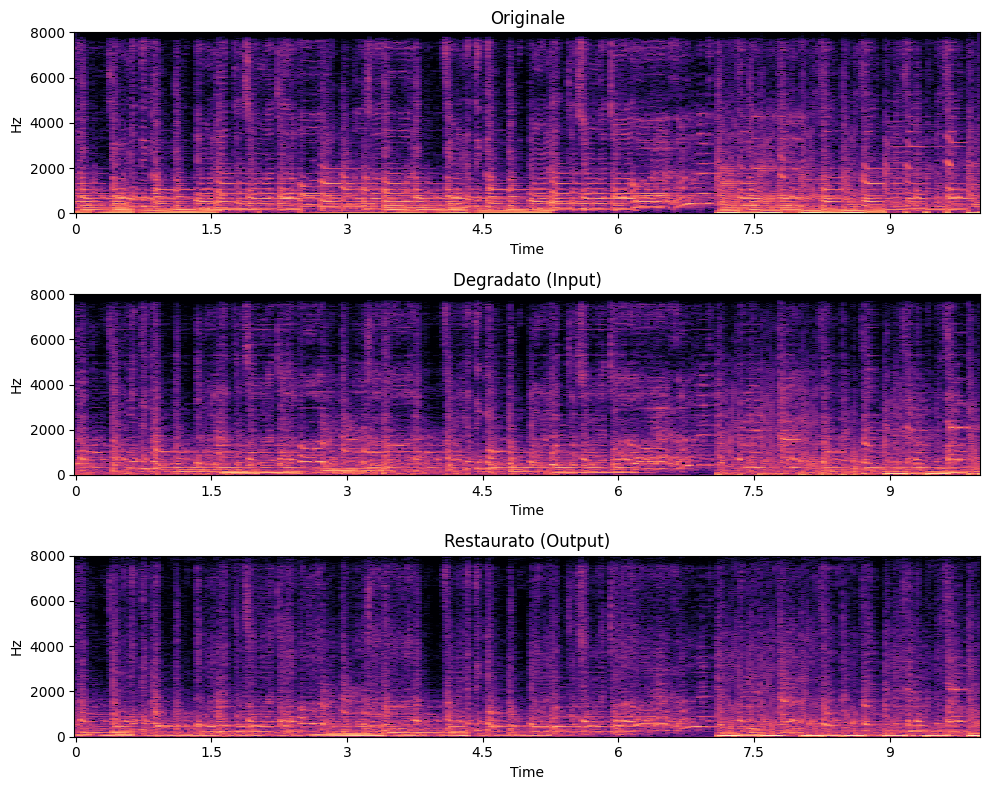


📈 REPORT METRICHE: -Prey, Scythermane, DJ FLORA, Nxxkz - Seu Amor Morto_v1.wav
Si-SDR: 5.99 -> 6.19 (Miglioramento: +0.20)
PESQ:   1.70 -> 1.68 (Miglioramento: -0.02)
--------------------------------------------------
🎧 ASCOLTO COMPARATIVO:
1. Originale:


2. Degradato:


3. Restaurato:


In [ ]:
#test con degradazione come MusicGen
import torch
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf  # Usiamo questo per salvare in modo sicuro
import numpy as np
from pathlib import Path
import sys
from importlib import reload

# Import moduli custom (con reload per sicurezza)
import src.metrics
import src.logger
reload(src.metrics)
reload(src.logger)

from src.models import LightweightUNet
from src.metrics import MetricsCalculator
from src.logger import ExperimentLogger

# --- SETUP INIZIALE ---
MODEL_CHECKPOINT = "models/v2/best_model.pt"
CLEAN_DIR = Path("data/musicgen_finetuning/splits_grouped/val/clean")
DEGRADED_DIR = Path("data/musicgen_finetuning/splits_grouped/val/degraded")
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# INIZIALIZZA SEMPRE QUESTI DUE PER SICUREZZA
metrics_calc = MetricsCalculator(device=DEVICE)
logger = ExperimentLogger(base_results_dir='results_experiments')

# Caricamento Modello e Tool (Singleton)
if 'model' not in globals():
    print(f"⏳ Caricamento Modello su {DEVICE}...")
    model = LightweightUNet().to(DEVICE)
    # Gestione sicura del caricamento pesi
    if torch.cuda.is_available():
        map_loc = None
    else:
        map_loc = torch.device('cpu')

    state_dict = torch.load(MODEL_CHECKPOINT, map_location=map_loc)
    model.load_state_dict(state_dict)
    model.eval()

    metrics_calc = MetricsCalculator(device=DEVICE)
    logger = ExperimentLogger(base_results_dir='results_experiments')
    print("✅ Modello e Tool pronti.")

# ==============================================================================
# 1. SCEGLI IL FILE DA ANALIZZARE
# ==============================================================================
FILENAME = "-Prey, Scythermane, DJ FLORA, Nxxkz - Seu Amor Morto_v1.wav"  # <--- CAMBIA SOLO QUI
# ==============================================================================

def analyze_audio(filename):
    clean_path = CLEAN_DIR / filename
    degraded_path = DEGRADED_DIR / filename
    temp_restored_path = "temp_preview.wav"

    if not degraded_path.exists():
        print(f"❌ File non trovato: {filename} in {DEGRADED_DIR}")
        return None

    print(f"🔄 Elaborazione: {filename}...")

    # A. INFERENZA
    # Carichiamo direttamente a 16kHz e in mono
    deg_np, sr = librosa.load(str(degraded_path), sr=16000, mono=True)

    # Conversione in tensore [Batch, Channels, Time] -> [1, 1, Time]
    deg_tensor = torch.from_numpy(deg_np).unsqueeze(0).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        restored_tensor = model(deg_tensor)

    # Output post-processato per salvataggio (rimuovi batch/channel dim)
    restored_np = restored_tensor.squeeze().cpu().numpy()

    # Salva con soundfile (evita errori di codec)
    sf.write(temp_restored_path, restored_np, 16000)

    # B. CALCOLO METRICHE
    print("📊 Calcolo metriche...")
    metrics = metrics_calc.calculate_all(str(clean_path), str(degraded_path), temp_restored_path)

    # C. VISUALIZZAZIONE SPETTROGRAMMI
    plt.figure(figsize=(10, 8))

    # Carica audio clean per confronto
    clean_np, _ = librosa.load(str(clean_path), sr=16000)

    # Calcola DB una volta sola per plot
    def plot_spec(y, ax, title):
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        librosa.display.specshow(D, sr=16000, x_axis='time', y_axis='hz', ax=ax)
        ax.set_title(title)

    ax1 = plt.subplot(3, 1, 1); plot_spec(clean_np, ax1, "Originale")
    ax2 = plt.subplot(3, 1, 2); plot_spec(deg_np, ax2, "Degradato (Input)")
    ax3 = plt.subplot(3, 1, 3); plot_spec(restored_np, ax3, "Restaurato (Output)")
    plt.tight_layout(); plt.show()

    # D. REPORT E ASCOLTO
    print(f"\n📈 REPORT METRICHE: {filename}")
    print(f"Si-SDR: {metrics['sisdr_baseline']:.2f} -> {metrics['sisdr_restored']:.2f} (Miglioramento: {metrics['delta_sisdr']:+.2f})")
    print(f"PESQ:   {metrics['pesq_baseline']:.2f} -> {metrics['pesq_restored']:.2f} (Miglioramento: {metrics['delta_pesq']:+.2f})")
    print("-" * 50)

    print("🎧 ASCOLTO COMPARATIVO:")
    print("1. Originale:")
    ipd.display(ipd.Audio(str(clean_path)))
    print("2. Degradato:")
    ipd.display(ipd.Audio(str(degraded_path)))
    print("3. Restaurato:")
    ipd.display(ipd.Audio(temp_restored_path))

    return {
        "filename": filename,
        "clean_path": str(clean_path),
        "degraded_path": str(degraded_path),
        "restored_path": temp_restored_path,
        "metrics": metrics
    }

# Esegui
CACHE_ESPERIMENTO = analyze_audio(FILENAME)


In [ ]:
# ==============================================================================
# 📝 SCRIVI QUI NOTE PERSONALI (opzionale)
# ==============================================================================
NOTE_PERSONALI = """

    """
# ==============================================================================
# CONFIGURAZIONE VERSIONAMENTO
# ==============================================================================
MODEL_VERSION = "v2.1"

if 'CACHE_ESPERIMENTO' not in globals() or CACHE_ESPERIMENTO is None:
    print("❌ Nessun dato in memoria! Esegui prima la cella di Analisi.")
else:
    print(f"💾 Salvataggio esperimento: {CACHE_ESPERIMENTO['filename']}...")

    # Creiamo un nome univoco che include la versione del modello
    # Es: "Justin_Bieber_THINGS_YOU_DO_v2_modelV2"
    unique_exp_name = f"{CACHE_ESPERIMENTO['filename'].replace('.wav', '')}_{MODEL_VERSION}"

    # Richiama il logger
    logger.log_experiment(
        song_name=unique_exp_name,
        clean_path=CACHE_ESPERIMENTO['clean_path'],
        degraded_path=CACHE_ESPERIMENTO['degraded_path'],
        restored_path=CACHE_ESPERIMENTO['restored_path'],
        notes=NOTE_PERSONALI + f"\nModello usato: {MODEL_VERSION}",
        metrics=CACHE_ESPERIMENTO['metrics']
    )



💾 Salvataggio esperimento: -Prey, Scythermane, DJ FLORA, Nxxkz - Seu Amor Morto_v1.wav...

📝 Salvataggio esperimento in: results_experiments/-Prey,_Scythermane,_DJ_FLORA,_Nxxkz_-_Seu_Amor_Morto_v1_v2.1
✅ Salvataggio completato: Audio, Immagini, Metriche e Note.


# Cella di ascolto v3: lista di canzoni da testare insieme

In [ ]:
import torch
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import numpy as np
from pathlib import Path
import sys
from importlib import reload

import src.metrics
import src.logger
reload(src.metrics)
reload(src.logger)

from src.models import LightweightUNet
from src.metrics import MetricsCalculator
from src.logger import ExperimentLogger

# --- CONFIGURAZIONE ---
MODEL_CHECKPOINT = "models/v3/best_model.pt"
MODEL_VERSION = "v3_batch"
CLEAN_DIR = Path("data/musicgen_finetuning/splits_grouped/val/clean")
DEGRADED_DIR = Path("data/musicgen_finetuning/splits_grouped/val/degraded")
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# ==============================================================================
# 📝 LISTA FILE DA TESTARE
# ==============================================================================
FILES_TO_TEST = [
    "Bad Bunny - BAILE INoLVIDABLE_v4.wav",
    "HUNTRX, EJAE, AUDREY NUNA, REI AMI, KPop Demon Hunters Cast - What It Sounds Like_v2.wav",
    "Morgan Wallen - Love Somebody_v4.wav"
]
# ==============================================================================

# Inizializzazione Singleton
metrics_calc = MetricsCalculator(device=DEVICE)
logger = ExperimentLogger(base_results_dir='results_experiments')

if 'model' not in globals():
    print(f"⏳ Caricamento Modello su {DEVICE}...")
    model = LightweightUNet().to(DEVICE)
    if torch.cuda.is_available():
        map_loc = None
    else:
        map_loc = torch.device('cpu')
    state_dict = torch.load(MODEL_CHECKPOINT, map_location=map_loc)
    model.load_state_dict(state_dict)
    model.eval()
    print("✅ Modello pronto.")

def process_single_file(filename):
    clean_path = CLEAN_DIR / filename
    degraded_path = DEGRADED_DIR / filename
    temp_restored_path = "temp_batch_preview.wav"

    if not degraded_path.exists():
        print(f"❌ SALTATO: {filename} non trovato.")
        return

    print(f"\n" + "="*60)
    print(f"🔄 ELABORAZIONE: {filename}")
    print("="*60)

    # 1. Inferenza
    deg_np, sr = librosa.load(str(degraded_path), sr=16000, mono=True)
    deg_tensor = torch.from_numpy(deg_np).unsqueeze(0).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        restored_tensor = model(deg_tensor)

    restored_np = restored_tensor.squeeze().cpu().numpy()
    sf.write(temp_restored_path, restored_np, 16000)

    # 2. Metriche
    metrics = metrics_calc.calculate_all(str(clean_path), str(degraded_path), temp_restored_path)

    # --- STAMPA METRICHE AL VOLO ---
    print(f"\n   📈 REPORT: {filename}")
    print(f"   {'METRICA':<10} | {'BASE':<8} | {'RESTORED':<8} | {'DELTA'}")
    print(f"   {'-'*45}")
    for k in ['sisdr', 'snr', 'pesq', 'stoi', 'lsd']:
        base = metrics.get(f'{k}_baseline', 0)
        rest = metrics.get(f'{k}_restored', 0)
        delta = rest - base
        print(f"   {k.upper():<10} | {base:<8.2f} | {rest:<8.2f} | {delta:+.2f}")
    print(f"   {'-'*45}")
    # -------------------------------

    # 3. Logging
    unique_exp_name = f"{filename.replace('.wav', '')}_{MODEL_VERSION}"
    logger.log_experiment(
        song_name=unique_exp_name,
        clean_path=str(clean_path),
        degraded_path=str(degraded_path),
        restored_path=temp_restored_path,
        notes=f"Batch Test Automatico - Modello {MODEL_VERSION}",
        metrics=metrics
    )
    print(f"   ✅ Log salvato in: results_experiments/{unique_exp_name}")

# --- CICLO ---
print(f"🚀 Avvio Batch Test su {len(FILES_TO_TEST)} file...")
for fname in FILES_TO_TEST:
    try:
        process_single_file(fname)
    except Exception as e:
        print(f"⚠️ Errore su {fname}: {e}")

print("\n🎉 TUTTI I TEST COMPLETATI!")


✅ Metriche PESQ e STOI caricate su GPU/CPU.
⏳ Caricamento Modello su cuda...
✅ Modello pronto.
🚀 Avvio Batch Test su 3 file...

🔄 ELABORAZIONE: Bad Bunny - BAILE INoLVIDABLE_v4.wav


/usr/local/lib/python3.12/dist-packages/torch/functional.py:681: UserWarning: A window was not provided. A rectangular window will be applied,which is known to cause spectral leakage. Other windows such as torch.hann_window or torch.hamming_window are recommended to reduce spectral leakage.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at /pytorch/aten/src/ATen/native/SpectralOps.cpp:836.)
  return _VF.stft(  # type: ignore[attr-defined]



   📈 REPORT: Bad Bunny - BAILE INoLVIDABLE_v4.wav
   METRICA    | BASE     | RESTORED | DELTA
   ---------------------------------------------
   SISDR      | 1.57     | 1.82     | +0.25
   SNR        | 3.86     | 3.71     | -0.15
   PESQ       | 1.43     | 1.40     | -0.03
   STOI       | 0.75     | 0.74     | -0.01
   LSD        | 1.07     | 1.03     | -0.04
   ---------------------------------------------

📝 Salvataggio esperimento in: results_experiments/Bad_Bunny_-_BAILE_INoLVIDABLE_v4_v3_batch
✅ Salvataggio completato: Audio, Immagini, Metriche e Note.
   ✅ Log salvato in: results_experiments/Bad Bunny - BAILE INoLVIDABLE_v4_v3_batch

🔄 ELABORAZIONE: HUNTRX, EJAE, AUDREY NUNA, REI AMI, KPop Demon Hunters Cast - What It Sounds Like_v2.wav

   📈 REPORT: HUNTRX, EJAE, AUDREY NUNA, REI AMI, KPop Demon Hunters Cast - What It Sounds Like_v2.wav
   METRICA    | BASE     | RESTORED | DELTA
   ---------------------------------------------
   SISDR      | 3.43     | 3.67     | +0.25
   SN

"Post Malone, Morgan Wallen - I Had Some Help (Feat. Morgan Wallen).wav",
    "Travis Scott - KICK OUT_v1.wav",
    "Travis Scott, Don Toliver - CHAMPAIN & VACAY_v4.wav",
    "-Prey, Scythermane, DJ FLORA, Nxxkz - Seu Amor Morto_v1.wav",
    "BLADELXRD - Rakura_v5.wav"

# Ricerca migliori file su cui testare

In [ ]:
#queste celle l'ho usate quando avevo ancora il primo dataset con degradazione secondo librosa

#questa l'ho usata per trovare i file più degradati sotto una certa soglia
import torch
import librosa
import numpy as np
from pathlib import Path
from tqdm import tqdm
from torchmetrics.functional.audio import scale_invariant_signal_distortion_ratio

# --- CONFIGURAZIONE ---
CLEAN_DIR = Path("data/splits_grouped/val/clean")      # Percorso Clean
DEGRADED_DIR = Path("data/splits_grouped/val/degraded") # Percorso Degraded
SOGLIA_SISDR = 10.0  # Cerchiamo file con Si-SDR inferiore a questo valore (dB)

def find_worst_files(clean_dir, degraded_dir, threshold_db=10.0):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"🕵️ Caccia ai file peggiori (Si-SDR < {threshold_db} dB)...")

    worst_files = []

    # Prendi tutti i file .wav nella cartella degraded
    deg_files = list(degraded_dir.glob("*.wav"))

    if not deg_files:
        print("❌ Nessun file trovato nella cartella degraded.")
        return

    print(f"📂 Scansione di {len(deg_files)} file...")

    # Usa TQDM per la barra di progresso
    for deg_path in tqdm(deg_files):
        filename = deg_path.name
        clean_path = clean_dir / filename

        if not clean_path.exists():
            continue # Salta se non c'è il corrispettivo clean

        try:
            # Caricamento veloce (solo 3 secondi per fare prima)
            y_deg, sr = librosa.load(str(deg_path), sr=16000, duration=3.0)
            y_clean, _ = librosa.load(str(clean_path), sr=16000, duration=3.0)

            # Taglia alla lunghezza minima
            min_len = min(len(y_deg), len(y_clean))
            if min_len < 1600: continue # Salta file vuoti/troppo corti

            # Calcolo Si-SDR
            t_deg = torch.tensor(y_deg[:min_len]).unsqueeze(0).to(device)
            t_clean = torch.tensor(y_clean[:min_len]).unsqueeze(0).to(device)

            score = scale_invariant_signal_distortion_ratio(t_deg, t_clean).item()

            if score < threshold_db:
                worst_files.append((filename, score))

        except Exception as e:
            print(f"⚠️ Errore su {filename}: {e}")

    # --- REPORT FINALE ---
    print("\n" + "="*50)
    print(f"🔥 RISULTATI: Trovati {len(worst_files)} file 'disastrati'.")
    print("="*50)

    # Ordina dal peggiore al "migliore" (crescente)
    worst_files.sort(key=lambda x: x[1])

    for fname, score in worst_files[:20]: # Mostra i primi 20
        print(f"📉 {score:.2f} dB | {fname}")

    if not worst_files:
        print("🎉 Incredibile! Nessun file sotto la soglia. Il tuo dataset è troppo pulito!")

# ESECUZIONE
find_worst_files(CLEAN_DIR, DEGRADED_DIR, SOGLIA_SISDR)


🕵️ Caccia ai file peggiori (Si-SDR < 10.0 dB)...
📂 Scansione di 132 file...


100%|██████████| 132/132 [01:01<00:00,  2.15it/s]


🔥 RISULTATI: Trovati 1 file 'disastrati'.
📉 9.65 dB | Travis Scott, Don Toliver - CHAMPAIN & VACAY_v4.wav


🕵️ INDAGINE SU: -Prey, Scythermane, DJ FLORA, Nxxkz - Seu Amor Morto_v5.wav

📊 STATISTICHE DIFFERENZA:
Differenza Media (L1): 0.022173
Differenza Massima:    0.569672
✅ I file sono diversi matematicamente.


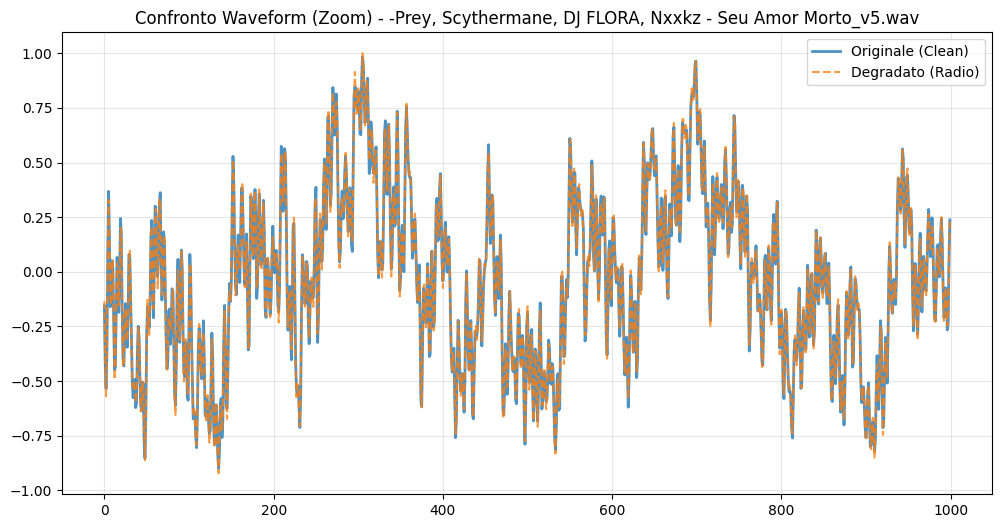

In [ ]:
#Cella per ricontrollare quanta differenza c'è tra file degradati e originali (differenza matematica pura)
import librosa
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Configurazione veloce
clean_dir = Path("data/splits_grouped/val/clean")
deg_dir = Path("data/splits_grouped/val/degraded")
filename = "-Prey, Scythermane, DJ FLORA, Nxxkz - Seu Amor Morto_v5.wav"

c_path = clean_dir / filename
d_path = deg_dir / filename

print(f"🕵️ INDAGINE SU: {filename}")

# 1. Carica
y_c, _ = librosa.load(c_path, sr=16000)
y_d, _ = librosa.load(d_path, sr=16000)

# Taglia alla lunghezza minima
min_len = min(len(y_c), len(y_d))
y_c = y_c[:min_len]
y_d = y_d[:min_len]

# 2. Differenza Matematica Pura
diff = np.abs(y_c - y_d)
mean_diff = np.mean(diff)
max_diff = np.max(diff)

print(f"\n📊 STATISTICHE DIFFERENZA:")
print(f"Differenza Media (L1): {mean_diff:.6f}")
print(f"Differenza Massima:    {max_diff:.6f}")

if mean_diff < 0.001:
    print("🚨 ALLARME: I file sono PRATICAMENTE IDENTICI! Controlla la generazione del dataset.")
else:
    print("✅ I file sono diversi matematicamente.")

# 3. Sovrapposizione Visiva (Zoom su un pezzetto)
plt.figure(figsize=(12, 6))
start = len(y_c) // 2  # Prendi un pezzo a metà
end = start + 1000     # 1000 campioni
plt.plot(y_c[start:end], label='Originale (Clean)', alpha=0.8, linewidth=2)
plt.plot(y_d[start:end], label='Degradato (Radio)', alpha=0.8, linestyle='--')
plt.title(f"Confronto Waveform (Zoom) - {filename}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
